# purpose of this notebook
1. split runs with "trigger event" 
    - e.g. binarize the values and identify start stop indices
2. extract ttl onsets
    - convert each event into trial number
    - do this based on two events: expect and actual

# TODO:
- [ ] identify BIDS scheme for physio data 
- [ ] flag files without ANISO
- [ ] flag files with less than 5 runs
- [ ] for those runs, we need to manually assign run numbers (biopac will collect back to back)
- [ ] change main_dir directory when running on discovery
- [ ] create metadata, of folders and how columns were calculated 
- [ ] remove unnecessary print statements
# 

estimated run time: 398.76

In [218]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os, glob, shutil, datetime, re
from pathlib import Path
import json

In [196]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [5,3]  # Bigger images

functions

In [146]:
def binarize_channel(data, origin_col, new_col, threshold, binary_h, binary_l):
    """
    data: pandas dataframe. acquisition file
    origin_col: columns with raw signal
    new_col: new columns for saving binarized origin_col values in
    threshold: int. threshold for binarizing values within pandas column
    binary_h, binary_l: two numbers. e.g. 5, 0 or 1, 0

    """
    data.loc[data[origin_col] > threshold, new_col] = binary_h
    data.loc[data[origin_col] <= threshold, new_col] = binary_l



In [5]:
# %% directories ___________________________________
# current_dir = os.getcwd()
# main_dir = Path(current_dir).parents[1]

# %% temporary
main_dir = '/Volumes/spacetop'
print(main_dir)
save_dir = os.path.join(main_dir, 'biopac', 'dartmouth', 'b03_extract_ttl')
print(save_dir)

/Volumes/spacetop
/Volumes/spacetop/biopac/dartmouth/b03_extract_ttl


In [6]:
acq_list = glob.glob(os.path.join(main_dir, 'biopac', 'dartmouth', 'b02_sorted', 'sub-' + ('[0-9]' * 4), '*', '*task-social*_physio.acq'), recursive = True)
flaglist = []

In [147]:
# extract info
acq = acq_list[3]
filename  = os.path.basename(acq)
sub = [match for match in filename.split('_') if "sub" in match][0]
ses = [match for match in filename.split('_') if "ses" in match][0] # 'ses-03'
task = [match for match in filename.split('_') if "task" in match][0]

In [148]:
print(sub, ses, task)

sub-0050 ses-04 task-social


# Previous code 
* run transitions were detected based on the Trigger channel.
* was not able to handle runs that started before an MR scanner. 
* See plot below. Note that this dataframe has a signal in the beginning.
* Previous code would treat this as the beginning of the experiment and break the code.

Text(0.5, 1.0, 'plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ')

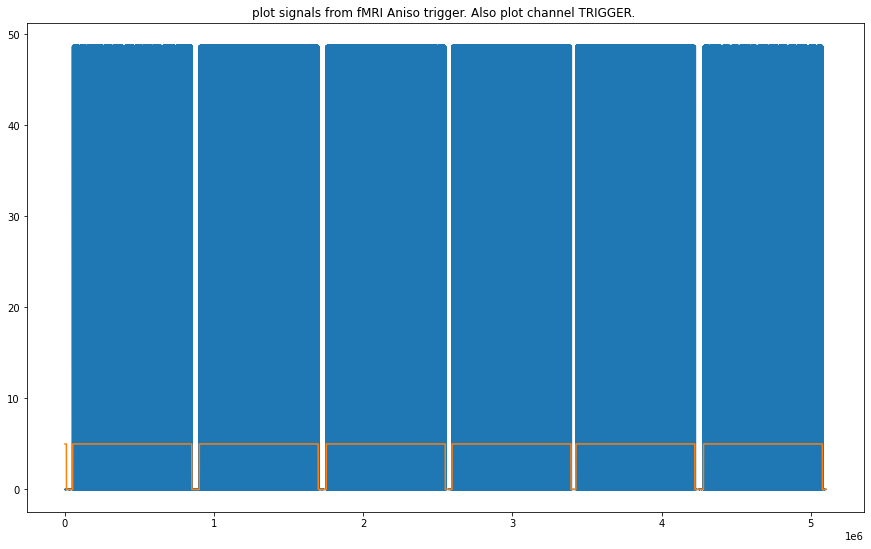

In [149]:
spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq) #, sampling_rate=1000, resample_method='interpolation', impute_missing=True)
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'])
plt.plot(spacetop_data['trigger'])
plt.title("plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ")

Text(0.5, 1.0, 'plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ')

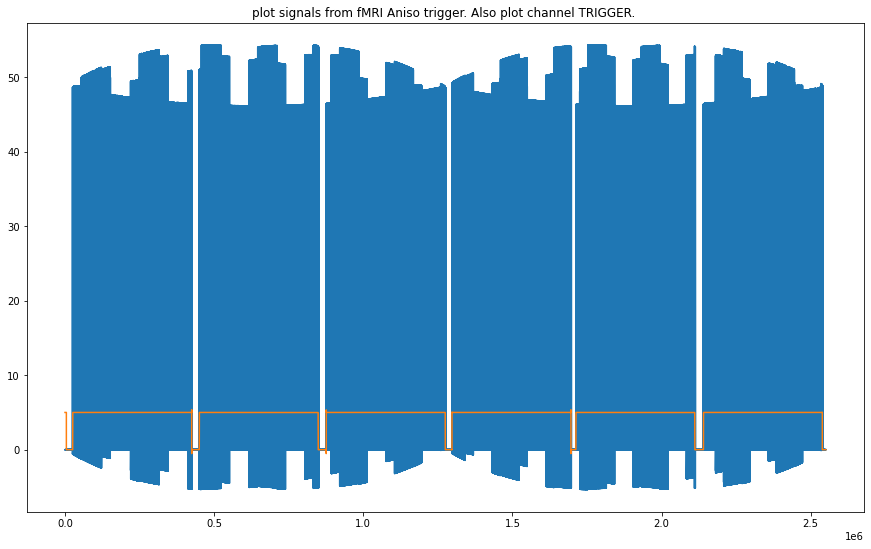

In [23]:
# spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq, sampling_rate=1000)
# plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'])
# plt.plot(spacetop_data['trigger'])
# plt.title("plot signals from fMRI Aniso trigger. Also plot channel TRIGGER. ")

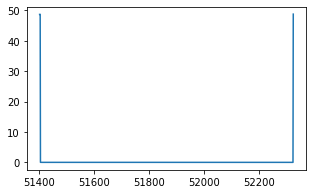

In [197]:
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'][51403:51403+460*2+1])

# What needs to be done
* Signals directly from Channel :: **fMRI Trigger - CBLCFMA - Current Feedba** should be the golden standard
* We'll use Pandas rolling window function to downsample transitions
* afterwards, I identify the min, max signals in the corresponding channel and binarize the signals if above/below the mid value of total signals

In [155]:
spacetop_data['mr_trigger'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=2000).mean()
spacetop_data['mr_trigger']
mid_val = (np.max(spacetop_data['mr_trigger']) - np.min(spacetop_data['mr_trigger']))/4
print(mid_val)
binarize_channel(spacetop_data,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                binary_l=0)
start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index
print(start_df)
print(stop_df)

0.07368698120117188
Int64Index([50485, 899341, 1750769, 2593713, 3425266, 4279822], dtype='int64')
Int64Index([853799, 1702655, 2554083, 3397028, 4228580, 5083136], dtype='int64')


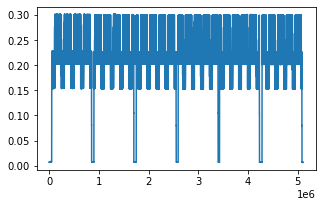

In [198]:
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=2000).mean())

# TADA! we now have a clean run transition, based on the fMRI aniso trigger channel

Text(0.5, 1.0, 'identify transitions')

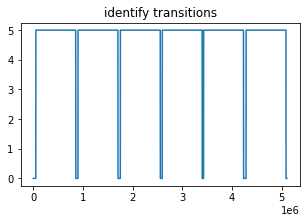

In [199]:
plt.plot(spacetop_data['mr_aniso'])
# plt.plot(spacetop_data['trigger'])
plt.title("identify transitions")

In [158]:
spacetop_data['mr_trigger'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=2000).mean()
# %% EV trigger :: identify transitions based on "trigger" ev 
mid_val = (np.max(spacetop_data['mr_trigger']) -
            np.min(spacetop_data['mr_trigger'])) / 4
binarize_channel(spacetop_data,
                    origin_col='mr_trigger',
                    new_col='mr_aniso',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
start_df = spacetop_data[spacetop_data['mr_aniso'] > spacetop_data['mr_aniso'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_aniso'] < spacetop_data['mr_aniso'].shift(1)].index

# %% EV TTL :: identify ttl events based on TTL column
spacetop_data['TTL'] = spacetop_data[
    'TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(
        window=2000).mean()
binarize_channel(spacetop_data,
                    origin_col='TTL',
                    new_col='ttl_aniso',
                    threshold=5,
                    binary_h=5,
                    binary_l=0)
# %% EV stimuli :: 
mid_val = (np.max(spacetop_data['administer']) - np.min(spacetop_data['administer']))/2
binarize_channel(spacetop_data,
            origin_col='administer',
            new_col='stimuli',
            threshold=mid_val,
            binary_h=5,
            binary_l=0)

df_transition = pd.DataFrame({
                'start_df': start_df, 
                'stop_df': stop_df
                })

for r in range(len(start_df)):
    if (stop_df[r] - start_df[r]) / 2000 < 300:
        spacetop_data.drop(spacetop_data.index[start_df[r]:stop_df[r]],
                            axis=0,
                            inplace=True)
        start_df.pop(r)
        stop_df.pop(r)
# identify runs with TTL signal
ttl_bool = []
for r in range(len(start_df)):
    bool_val = np.unique(spacetop_data.iloc[df_transition.start_df[r]:df_transition.stop_df[r],spacetop_data.columns.get_loc('ttl_aniso')]).any()
    ttl_bool.append(bool_val)

acq_runs_with_ttl = [i for i, x in enumerate(ttl_bool) if x]
print(f"acq_runs_with_ttl: {acq_runs_with_ttl}")


acq_runs_with_ttl: [1, 4]


Text(0.5, 1.0, 'blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

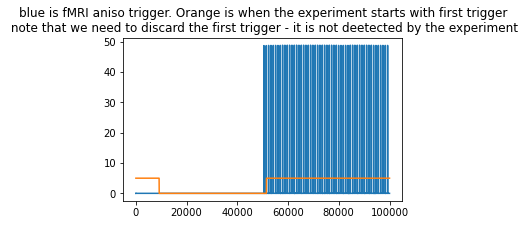

In [200]:
# plt.plot(spacetop_data['mr_aniso'][0:200000])
plt.plot(spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'][0:100000])
plt.plot(spacetop_data['trigger'][0:100000])
plt.title('blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

# Remedy for removing the first TR while accoungint for run duration
* there are three datapoints per TR, due to 2000 hz high sampling rate
* 1. we're going to roll that over by using a sliding window of 3 [ mr_trigger & spike ]
* 2. from that, we'll binarize values. The manipulation check is whether we get 872 TRs
* 3. With a sliding window of 2000, we will identify run transitions [ mr_trigger_boxcar & mr_aniso ]

In [210]:
spacetop_data['mr_aniso'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=3).mean()
binarize_channel(spacetop_data,
                    origin_col='mr_aniso',
                    new_col='spike',
                    threshold=40,
                    binary_h=5,
                    binary_l=0)
start_spike = spacetop_data[spacetop_data['spike'] > spacetop_data['spike'].shift(1)].index
stop_spike = spacetop_data[spacetop_data['spike'] < spacetop_data['spike'].shift(1)].index
print(f"number of spikes within experiment: {len(start_spike)}")
spacetop_data['bin_spike'] = 0
spacetop_data.loc[start_spike, 'bin_spike'] = 5
# %% EV trigger :: identify transitions based on "trigger" ev 
spacetop_data['mr_aniso_boxcar'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=2000).mean()
mid_val = (np.max(spacetop_data['mr_aniso_boxcar']) -
            np.min(spacetop_data['mr_aniso_boxcar'])) / 4
binarize_channel(spacetop_data,
                    origin_col='mr_aniso_boxcar',
                    new_col='mr_boxcar',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
start_df = spacetop_data[spacetop_data['mr_boxcar'] > spacetop_data['mr_boxcar'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_boxcar'] < spacetop_data['mr_boxcar'].shift(1)].index
print(f"start_df: {start_df}")
print(f"stop_df: {stop_df}")
print(len(start_df))

# _____________ adjust one TR (remove it!)_____________
sdf= spacetop_data.copy()
sdf.loc[start_df, 'bin_spike'] = 0

nstart_df = sdf[sdf['bin_spike'] > sdf['bin_spike'].shift(1)].index
nstop_df = sdf[sdf['bin_spike'] < sdf['bin_spike'].shift(1)].index
print(nstart_df)
print(nstop_df)

sdf['adjusted_boxcar'] = sdf['bin_spike'].rolling(window=2000).mean()
mid_val = (np.max(sdf['adjusted_boxcar']) -
            np.min(sdf['adjusted_boxcar'])) / 4
binarize_channel(sdf,
                    origin_col='adjusted_boxcar',
                    new_col='adjust_run',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
astart_df = sdf[sdf['adjust_run'] > sdf['adjust_run'].shift(1)].index
astop_df = sdf[sdf['adjust_run'] < sdf['adjust_run'].shift(1)].index
print(f"adjusted start_df: {astart_df}")
print(f"adjusted stop_df: {astop_df}")
# sdf.loc[start_df[0]-2:start_df[0]+2, 'fMRI Trigger - CBLCFMA - Current Feedba'] = 0

number of spikes within experiment: 5232
start_df: Int64Index([50485, 899341, 1750769, 2593713, 3425266, 4279822], dtype='int64')
stop_df: Int64Index([853799, 1702655, 2554083, 3397028, 4228580, 5083136], dtype='int64')
6
Int64Index([  51405,   52325,   53245,   54165,   55085,   56005,   56925,
              57845,   58765,   59685,
            ...
            5072858, 5073778, 5074698, 5075618, 5076538, 5077458, 5078378,
            5079298, 5080218, 5081138],
           dtype='int64', length=5226)
Int64Index([  51406,   52326,   53246,   54166,   55086,   56006,   56926,
              57846,   58766,   59686,
            ...
            5072859, 5073779, 5074699, 5075619, 5076539, 5077459, 5078379,
            5079299, 5080219, 5081139],
           dtype='int64', length=5226)
adjusted start_df: Int64Index([51405, 900261, 1751689, 2594633, 3426186, 4280742], dtype='int64')
adjusted stop_df: Int64Index([853801, 1702656, 2554085, 3397029, 4228581, 5083138], dtype='int64')


In [214]:
(astop_df - astart_df)/2000
# astart_df-start_df

Float64Index([401.198, 401.1975, 401.198, 401.198, 401.1975, 401.198], dtype='float64')

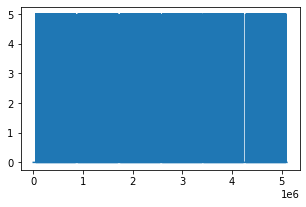

In [208]:
plt.plot(spacetop_data['bin_spike'])

Text(0.5, 1.0, 'blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

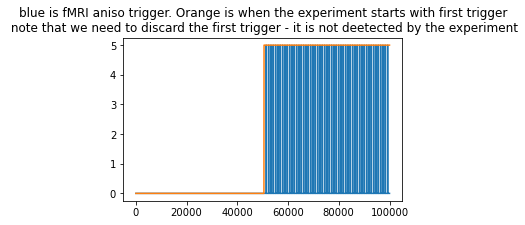

In [203]:
# plt.plot(spacetop_data['mr_aniso'][0:200000])
plt.plot(sdf['bin_spike'][0:100000])
plt.plot(sdf['mr_aniso'][0:100000])
plt.title('blue is fMRI aniso trigger. Orange is when the experiment starts with first trigger\n note that we need to discard the first trigger - it is not deetected by the experiment')

# Note that TTL transisions are not as clear
* we notice a blue spike in the last run
* The last run is not a pain run
* However, we may have gotten that spike because we turned the TSA2 off during that last run
* Let's remove that odd blue spike. 

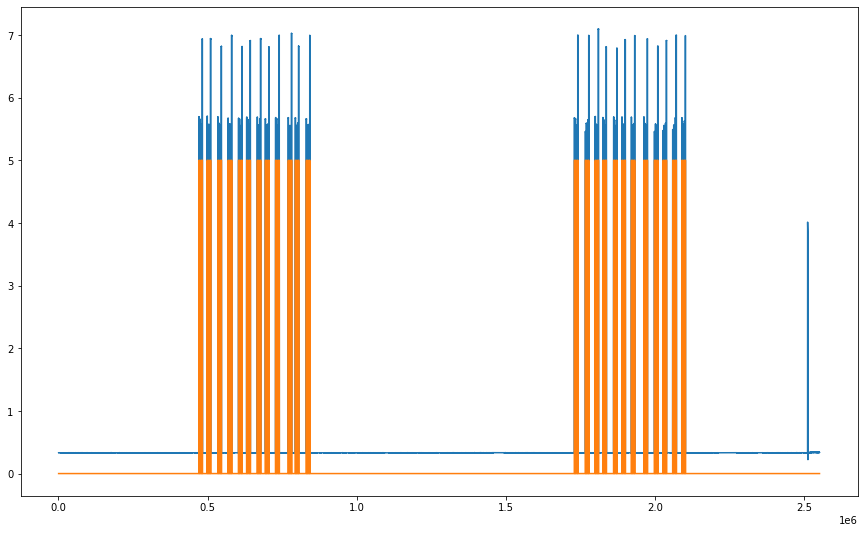

In [107]:
plt.plot(spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=1000).mean())
spacetop_data['TTL'] = spacetop_data['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=1000).mean()
spacetop_data.loc[spacetop_data['TTL'] > 5, 'ttl_aniso'] = 5
spacetop_data.loc[spacetop_data['TTL'] <= 5, 'ttl_aniso'] = 0
plt.plot(spacetop_data['ttl_aniso'])

* Now we're removed the odd blue spike, reflected in the green bars
* We did this by identifying a rollowing window and binarizing signals based on a threshold of 5 (which is the recorded signal for a TTL from Medoc)

Text(0.5, 1.0, 'identify transitions')

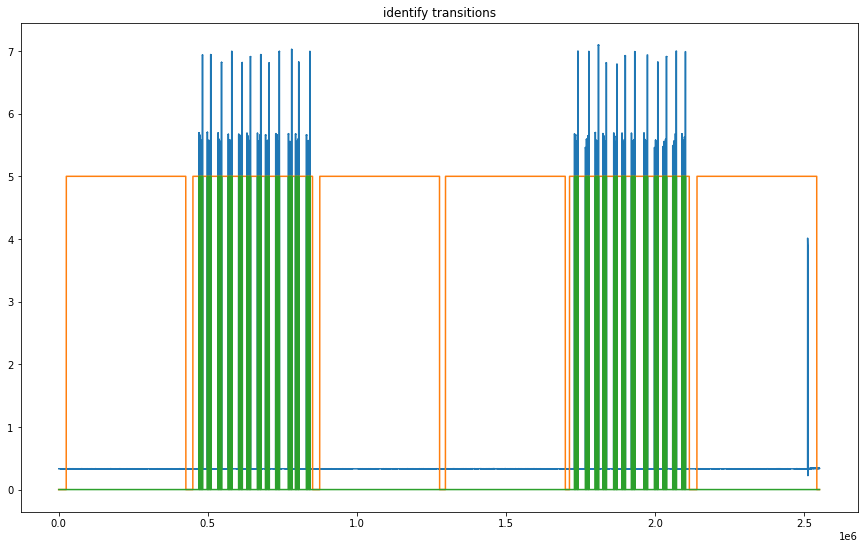

In [108]:
plt.plot(spacetop_data['TTL'])
plt.plot(spacetop_data['mr_aniso'])
plt.plot(spacetop_data['ttl_aniso'])
plt.title("identify transitions")
# Green does not have that spike anymore

In [109]:
print(start_df)
print(stop_df)

Int64Index([25702, 450129, 875384, 1296856, 1712633, 2139910], dtype='int64')
Int64Index([426440, 851327, 1277041, 1698513, 2114289, 2541567], dtype='int64')


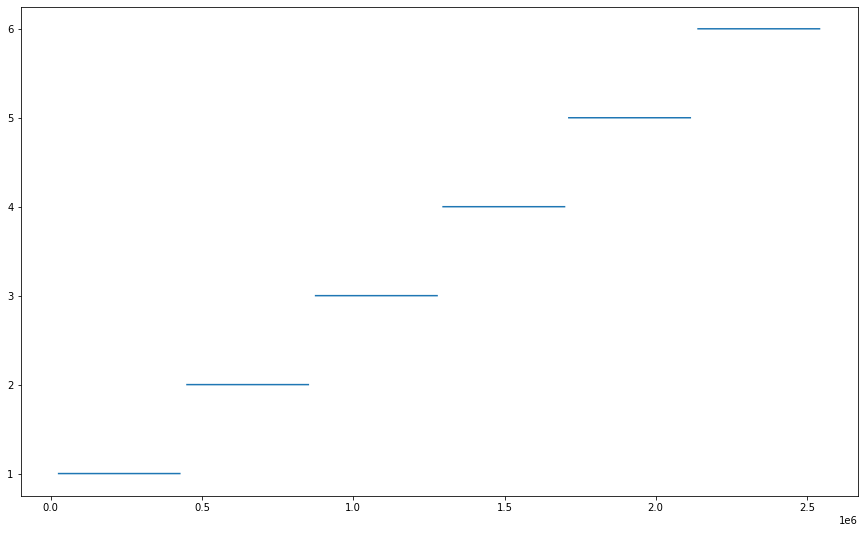

In [110]:
for r in range(len(start_df)):
    spacetop_data.at[start_df[r]:stop_df[r], 'run_num'] = r+1
plt.plot(spacetop_data.run_num)

In [112]:
run_len = len(df_transition)
# if run_len == 6:
for i, run_num in enumerate(acq_runs_with_ttl):
    run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
    if 380 < len(run_subset)/2000 < 410:
        print(i, run_num, len(run_subset)/2000 )

NameError: name 'df_transition' is not defined

In [1]:
len(run_subset)/2000

NameError: name 'run_subset' is not defined

In [154]:
run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]
len(run_subset)/2000

401.1185

In [145]:

# %%    # FOR LOOP START _________________
run_len = len(df_transition)
if run_len == 6:
    for i, run_num in enumerate(runs_with_ttl):
        print(i, run_num)

        run = f"run-{run_num + 1:02d}"
        print(run)
        run_subset = spacetop_data.loc[spacetop_data['run_num'] == run_num+1]

        # run_subset = spacetop_data[df_transition.start_df[run_num]: df_transition.stop_df[run_num]]
        run_df = run_subset.reset_index()
        # identify events :: expect and actual _________________
        start_expect = run_df[run_df['expect'] > run_df[ 'expect'].shift(1)]
        start_actual = run_df[run_df['actual'] > run_df[ 'actual'].shift(1)]
        stop_actual= run_df[run_df['actual'] < run_df[ 'actual'].shift(1)]

        # identify events :: stimulli _________________
        start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
        stop_stim= run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
        events = nk.events_create(event_onsets=list(start_stim.index), 
        event_durations = list((stop_stim.index-start_stim.index)/spacetop_samplingrate))

        # transform events :: transform to onset _________________
        expect_start = start_expect.index/spacetop_samplingrate
        actual_end = stop_actual.index/spacetop_samplingrate
        stim_start = start_stim.index/spacetop_samplingrate
        stim_end = stop_stim.index/spacetop_samplingrate
        stim_onset = events['onset']/spacetop_samplingrate

        # build pandas dataframe _________________
        df_onset = pd.DataFrame({
            'expect_start': expect_start, 
            'actual_end': actual_end,
            'stim_start': np.nan,
            'stim_end':np.nan
        })

        df_stim = pd.DataFrame({
            'stim_start': stim_start, 
            'stim_end': stim_end
            })

        final_df = pd.DataFrame()

0 1
run-02
1 4
run-05


In [215]:
acq


'/Volumes/spacetop/biopac/dartmouth/b02_sorted/sub-0050/ses-04/sub-0050_ses-04_task-social_recording-ppg-eda_physio.acq'

In [217]:
runmeta = pd.read_csv('/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/spacetop_task-social_run-metadata.csv')

In [222]:

spacetop_data, spacetop_samplingrate = nk.read_acqknowledge(acq)
# ____________________________________ identify TR spikes ____________________________________
spacetop_data['mr_aniso'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=3).mean()
binarize_channel(spacetop_data,
                    origin_col='mr_aniso',
                    new_col='spike',
                    threshold=40,
                    binary_h=5,
                    binary_l=0)
start_spike = spacetop_data[spacetop_data['spike'] > spacetop_data['spike'].shift(1)].index
stop_spike = spacetop_data[spacetop_data['spike'] < spacetop_data['spike'].shift(1)].index
print(f"number of spikes within experiment: {len(start_spike)}")
spacetop_data['bin_spike'] = 0
spacetop_data.loc[start_spike, 'bin_spike'] = 5
# ____________________________ identify run transitions based on TR spikes ____________________________________
spacetop_data['mr_aniso_boxcar'] = spacetop_data['fMRI Trigger - CBLCFMA - Current Feedba'].rolling(window=2000).mean()
mid_val = (np.max(spacetop_data['mr_aniso_boxcar']) -
            np.min(spacetop_data['mr_aniso_boxcar'])) / 4
binarize_channel(spacetop_data,
                    origin_col='mr_aniso_boxcar',
                    new_col='mr_boxcar',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
start_df = spacetop_data[spacetop_data['mr_boxcar'] > spacetop_data['mr_boxcar'].shift(1)].index
stop_df = spacetop_data[spacetop_data['mr_boxcar'] < spacetop_data['mr_boxcar'].shift(1)].index
print(f"start_df: {start_df}")
print(f"stop_df: {stop_df}")
print(len(start_df))

# _____________ adjust one TR (remove it!)_____________
sdf= spacetop_data.copy()
sdf.loc[start_df, 'bin_spike'] = 0

nstart_df = sdf[sdf['bin_spike'] > sdf['bin_spike'].shift(1)].index
nstop_df = sdf[sdf['bin_spike'] < sdf['bin_spike'].shift(1)].index
print(nstart_df)
print(nstop_df)

sdf['adjusted_boxcar'] = sdf['bin_spike'].rolling(window=2000).mean()
mid_val = (np.max(sdf['adjusted_boxcar']) -
            np.min(sdf['adjusted_boxcar'])) / 4
binarize_channel(sdf,
                    origin_col='adjusted_boxcar',
                    new_col='adjust_run',
                    threshold=mid_val,
                    binary_h=5,
                    binary_l=0)
astart_df = sdf[sdf['adjust_run'] > sdf['adjust_run'].shift(1)].index
astop_df = sdf[sdf['adjust_run'] < sdf['adjust_run'].shift(1)].index
print(f"adjusted start_df: {astart_df}")
print(f"adjusted stop_df: {astop_df}")
# sdf.loc[start_df[0]-2:start_df[0]+2, 'fMRI Trigger - CBLCFMA - Current Feedba'] = 0

# _____________ %% EV TTL :: identify ttl events based on TTL column _____________
sdf['TTL'] = sdf['TSA2 TTL - CBLCFMA - Current Feedback M'].rolling(window=2000).mean()
sdf.loc[sdf['TTL'] > 5, 'ttl_aniso'] = 5
sdf.loc[sdf['TTL'] <= 5, 'ttl_aniso'] = 0

# _____________ %% EV stimuli :: _____________
mid_val = (np.max(sdf['administer']) - np.min(sdf['administer']))/2
sdf.loc[sdf['administer'] > mid_val, 'stimuli'] = 5
sdf.loc[sdf['administer'] <= mid_val, 'stimuli'] = 0

df_transition = pd.DataFrame({
    'start_df': astart_df,
    'stop_df': astop_df
})
# TODO: if run smaller than 300s, drop and remove from pandas
# POP item from start_df, stop_df
# spacetop_data.at[start_df[r]:stop_df[r], 'run_num'] = r+1
for r in range(len(astart_df)):
    if (astop_df[r] - astart_df[r]) / 2000 < 300:
        sdf.drop(sdf.index[astart_df[r]:astop_df[r]],
                            axis=0,
                            inplace=True)
        astart_df.pop(r)
        astop_df.pop(r)

# identify runs with TTL signal
ttl_bool = []; runs_with_ttl = []; new_meta_run_with_ttl = []
for r in range(len(astart_df)):
    bool_val = np.unique(sdf.iloc[
        df_transition.start_df[r]:df_transition.stop_df[r],
        sdf.columns.get_loc('ttl_aniso')]).any()
    ttl_bool.append(bool_val)
    sdf.at[start_df[r]:stop_df[r], 'run_num'] = r+1

acq_runs_with_ttl = [i for i, x in enumerate(ttl_bool) if x]
print(f"acq_runs_with_ttl: {acq_runs_with_ttl}")

# TODO: check if runs_with_ttl matches the index from the ./social_influence-analysis/data/spacetop_task-social_run-metadata.csv

a = runmeta.loc[(runmeta['sub'] == sub) & (runmeta['ses'] == ses)]
ttl_list_from_meta = a.columns[a.eq('pain').any()]
meta_runs_with_ttl = [int(re.findall('\d+', s)[0])  for s in list(ttl_list_from_meta) ]
new_meta_run_with_ttl[:] = [m - 1 for m in meta_runs_with_ttl]

print(f"new_meta_run_with_ttl: {new_meta_run_with_ttl}")
# ____________________________________ identify TTL signals and trials ____________________________________
# run_len = len(df_transition)
# if run_len == 6:


number of spikes within experiment: 5232
start_df: Int64Index([50485, 899341, 1750769, 2593713, 3425266, 4279822], dtype='int64')
stop_df: Int64Index([853799, 1702655, 2554083, 3397028, 4228580, 5083136], dtype='int64')
6
Int64Index([  51405,   52325,   53245,   54165,   55085,   56005,   56925,
              57845,   58765,   59685,
            ...
            5072858, 5073778, 5074698, 5075618, 5076538, 5077458, 5078378,
            5079298, 5080218, 5081138],
           dtype='int64', length=5226)
Int64Index([  51406,   52326,   53246,   54166,   55086,   56006,   56926,
              57846,   58766,   59686,
            ...
            5072859, 5073779, 5074699, 5075619, 5076539, 5077459, 5078379,
            5079299, 5080219, 5081139],
           dtype='int64', length=5226)
adjusted start_df: Int64Index([51405, 900261, 1751689, 2594633, 3426186, 4280742], dtype='int64')
adjusted stop_df: Int64Index([853801, 1702656, 2554085, 3397029, 4228581, 5083138], dtype='int64')
acq_runs_with

In [223]:
acq_runs_with_ttl

[1, 4]

In [225]:
if acq_runs_with_ttl == new_meta_run_with_ttl:
    
    print(f"runs with ttl: {acq_runs_with_ttl}")
    for i, run_num in enumerate(acq_runs_with_ttl):
        run_subset = sdf.loc[sdf['run_num'] ==  run_num + 1]
        print(len(run_subset) / spacetop_samplingrate)
        if 300 < len(run_subset)/spacetop_samplingrate < 450:  # TODO: check if run length is around 389 s
            print(i, run_num)

            run = f"run-{run_num + 1:02d}"
            print(run)

            run_df = run_subset.reset_index()
            # identify events :: expect and actual _________________
            start_expect = run_df[
                run_df['expect'] > run_df['expect'].shift(1)]
            start_actual = run_df[
                run_df['actual'] > run_df['actual'].shift(1)]
            stop_actual = run_df[
                run_df['actual'] < run_df['actual'].shift(1)]

            # identify events :: stimulli _________________
            start_stim = run_df[
                run_df['stimuli'] > run_df['stimuli'].shift(1)]
            stop_stim = run_df[
                run_df['stimuli'] < run_df['stimuli'].shift(1)]
            events = nk.events_create(
                event_onsets=list(start_stim.index),
                event_durations=list(
                    (stop_stim.index - start_stim.index) /
                    spacetop_samplingrate))

            # transform events :: transform to onset _________________
            expect_start = start_expect.index / spacetop_samplingrate
            actual_end = stop_actual.index / spacetop_samplingrate
            stim_start = start_stim.index / spacetop_samplingrate
            stim_end = stop_stim.index / spacetop_samplingrate
            stim_onset = events['onset'] / spacetop_samplingrate

            # build pandas dataframe _________________
            df_onset = pd.DataFrame({
                'expect_start': expect_start,
                'actual_end': actual_end,
                'stim_start': np.nan,
                'stim_end': np.nan
            })

            df_stim = pd.DataFrame({
                'stim_start': stim_start,
                'stim_end': stim_end
            })
            # ____________________________________ identify boundary conditions and assign TTL event to specific trial ____________________________________
            # based on information of "expect, actual" events, we will assign a trial number to stimulus events
            # RESOURCE: https://stackoverflow.com/questions/62300474/filter-all-rows-in-a-pandas-dataframe-where-a-given-value-is-between-two-columnv
            for i in range(len(df_stim)):
                idx = pd.IntervalIndex.from_arrays(
                    df_onset['expect_start'], df_onset['actual_end'])
                start_val = df_stim.iloc[i][df_stim.columns.get_loc(
                    'stim_start')]
                interval_idx = df_onset[idx.contains(
                    start_val)].index[0]
                df_onset.iloc[
                    interval_idx,
                    df_onset.columns.get_loc('stim_start')] = start_val

                end_val = df_stim.iloc[i][df_stim.columns.get_loc(
                    'stim_end')]
                interval_idx = df_onset[idx.contains(end_val)].index[0]
                df_onset.iloc[
                    interval_idx,
                    df_onset.columns.get_loc('stim_end')] = end_val
                print(
                    f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}"
                )
            start_ttl = run_df[
                run_df['ttl_aniso'] > run_df['ttl_aniso'].shift(1)]
            stop_ttl = run_df[
                run_df['ttl_aniso'] < run_df['ttl_aniso'].shift(1)]
            ttl_onsets = list(start_ttl.index +
                                (stop_ttl.index - start_ttl.index) /
                                2) / spacetop_samplingrate
            # print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")
            # define empty TTL data frame
            df_ttl = pd.DataFrame(
                np.nan,
                index=np.arange(len(df_onset)),
                columns=['ttl_1', 'ttl_2', 'ttl_3', 'ttl_4'])
            # identify which set of TTLs fall between expect and actual
            pad = 1  # seconds. you may increase the value to have a bigger event search interval
            df_onset['expect_start_interval'] = df_onset[
                'expect_start'] - pad
            df_onset[
                'actual_end_interval'] = df_onset['actual_end'] + pad
            adjusted = df_onset['actual_end_interval']
            adjusted.iloc[-1, :] = len(run_subset) / 2000
            a_idx = pd.IntervalIndex.from_arrays(
                df_onset['expect_start_interval'], adjusted)
            for i in range(len(ttl_onsets)):
                val = ttl_onsets[i]  #
                print(f"{i}-th value: {val}")
                empty_cols = []
                interval_idx = df_onset[a_idx.contains(val)].index[
                    0]  #
                print(f"\t\t* interval index: {interval_idx}")
                mask = df_ttl.loc[[interval_idx]].isnull()
                empty_cols = list(
                    itertools.compress(
                        np.array(df_ttl.columns.to_list()),
                        mask.values[0]))  #
                print(f"\t\t* empty columns: {empty_cols}")
                df_ttl.loc[df_ttl.index[interval_idx],
                            str(empty_cols[0])] = val  #
                print(
                    f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row"
                )

            # fdf = pd.concat([df_onset, df_ttl],axis = 1)
            fdf = pd.merge(df_onset,
                            df_ttl,
                            left_index=True,
                            right_index=True)
            fdf['ttl_r1'] = fdf['ttl_1'] - fdf['stim_start']
            fdf['ttl_r2'] = fdf['ttl_2'] - fdf['stim_start']
            fdf['ttl_r3'] = fdf['ttl_3'] - fdf['stim_start']
            fdf['ttl_r4'] = fdf['ttl_4'] - fdf['stim_start']
            fdf['plateau_dur'] = fdf['ttl_3'] - fdf['ttl_2']
            save_filename = f"{sub}_{ses}_{task}_{run}_physio-ttl.csv"
            new_dir = os.path.join(save_dir, task, sub, ses)
            print(f"directory: {new_dir}")
            Path(new_dir).mkdir(parents=True, exist_ok=True)
            fdf.reset_index(inplace=True)
            fdf = fdf.rename(columns={'index': 'trial_num'})
            fdf.to_csv(os.path.join(new_dir, save_filename),
                        index=False)

runs with ttl: [1, 4]
401.6575
0 1
run-02
this is the 0-th iteration. stim value is 21.156, and is in between index 0
this is the 1-th iteration. stim value is 48.679, and is in between index 1
this is the 2-th iteration. stim value is 84.621, and is in between index 2
this is the 3-th iteration. stim value is 118.7905, and is in between index 3
this is the 4-th iteration. stim value is 153.784, and is in between index 4
this is the 5-th iteration. stim value is 181.1775, and is in between index 5
this is the 6-th iteration. stim value is 216.6995, and is in between index 6
this is the 7-th iteration. stim value is 243.7755, and is in between index 7
this is the 8-th iteration. stim value is 277.9795, and is in between index 8
this is the 9-th iteration. stim value is 320.396, and is in between index 9
this is the 10-th iteration. stim value is 344.181, and is in between index 10
this is the 11-th iteration. stim value is 380.97, and is in between index 11
0-th value: 21.6635
		* inter